# **Importing Libraries and Modules and Model**

In [1]:
import sys, os
%pip install transformer-lens==1.12.0
!apt install -y graphviz
!apt install libgraphviz-dev
%pip install pygraphviz
%pip install cmapy
!git clone https://github.com/hannamw/EAP-positional.git
%cd EAP-positional
!git checkout tutorial
%pip install -e .
sys.path.append(os.getcwd())
%cd ..


!pip install datasets
!pip install jaxtyping
!pip install better_abc
!pip install fancy_einsum
!pip install wandb
!pip install einops==0.7.0

!pip install datasets transformers huggingface_hub
!apt-get install git-lfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
  Using cached nvidi

In [2]:
import torch
from torch import Tensor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from typing import List, Union, Optional, Tuple, Literal, Callable
from functools import partial
from IPython.display import Image, display

from tqdm import tqdm

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, ActivationCache
import plotly.io as pio

from transformers import pipeline
from pprint import pprint
from einops import einsum

pio.renderers.default = "colab"

device = "cuda" if torch.cuda.is_available() else "cpu"
if not torch.cuda.is_available():
    print("WARNING: Running on CPU. Did you remember to set your Colab accelerator to GPU?")

In [3]:
model_name = 'gpt2'
model = HookedTransformer.from_pretrained(model_name, device=device)
model.cfg.use_attn_in = True
model.cfg.use_split_qkv_input = True
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2 into HookedTransformer


# **Reading and Modifying Dataset**

In [4]:
s = "abc people are so"
logits=model(s).squeeze(0).cpu()
probs = torch.softmax(logits, dim=-1)
probs, next_tokens = torch.topk(probs[-1], 5)
for prob, token_id in zip(probs, next_tokens):
  token = model.tokenizer.decode(token_id.item())
  print(f"{token.strip()}\t{prob.item():.3f}")
print(f"The token length of the sentence is {len(logits)}")

scared	0.041
sick	0.019
much	0.019
busy	0.018
angry	0.017
The token length of the sentence is 5


In [5]:
df = pd.read_csv('/content/drive/MyDrive/MI /Nationalities_Dataset_Corrupted.csv')
print(df.iloc[0])

sentence     Afghan people are so
corrupted       abc people are so
Name: 0, dtype: object


In [6]:
def batch_dataset(df, batch_size=1):
    sentence, corrupted = [df[col].tolist() for col in ['sentence', 'corrupted']]
    sentence = [sentence[i:i+batch_size] for i in range(0, len(df), batch_size)]
    corrupted = [corrupted[i:i+batch_size] for i in range(0, len(df), batch_size)]
    return [(sentence[i], corrupted[i]) for i in range(len(sentence))]

dataset = batch_dataset(df, batch_size=1)
print(dataset[0])

(['Afghan people are so'], ['abc people are so'])


# **Calculate Pos,Neg Scores, Labels and Pos,Neg Datasets**

In [7]:
s_list = []
# Here k denotes the number of topk predictions.
k=10

topk_pred = np.empty((len(dataset), k), dtype=object)
predicted = np.empty((len(dataset), k), dtype=object)
Probabilities = np.zeros((len(dataset),k), dtype=float)

for i, (sentence,_) in enumerate(dataset):
  s_list.append(sentence)
  logits = model(s_list[i]).squeeze(0).cpu()
  probs = torch.softmax(logits, dim=-1)
  probs, next_tokens = torch.topk(probs[-1], k)
  for j, (prob, token_id) in enumerate(zip(probs, next_tokens)):
    token = model.tokenizer.decode(token_id.item())
    predicted[i,j] = s_list[i][0] + token  # Append the predicted token to the current text
    topk_pred[i,j] = token
    Probabilities[i,j] = prob.item()

In [8]:
predicted[0,0]

'Afghan people are so desperate'

In [9]:

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [10]:
def text_to_sentiment(sentence):
  result = sentiment_pipeline(sentence)[0]
  if result['label'] == "POSITIVE": return result['score']
  if result['label'] == "NEGATIVE": return -result['score']
  raise ValueError("Unknown result label: " + result['label'])

In [11]:
text_to_sentiment("I hate you")

-0.9991129040718079

In [12]:
text_to_sentiment("I love you")

0.9998656511306763

In [13]:
print(f"{predicted[0, 0]} ::: {text_to_sentiment(predicted[0, 0])}")

Afghan people are so desperate ::: -0.9971902966499329


In [14]:
Senti_Scores = np.empty((len(dataset), k), dtype=object)
Total_Positive_Score = np.zeros(len(dataset))
Total_Negative_Score = np.zeros(len(dataset))

Positive_Probs = np.zeros(len(dataset))
Negative_Probs = np.zeros(len(dataset))

positive_sentiment_labels = [[] for _ in range(len(dataset))]
negative_sentiment_labels = [[] for _ in range(len(dataset))]

for i in range(len(dataset)):
  for j in range(k):
    Senti_Scores[i,j] = text_to_sentiment(predicted[i,j])
    if Senti_Scores[i,j] >= 0:
      Total_Positive_Score[i] += Senti_Scores[i,j]
      positive_sentiment_labels[i].append(topk_pred[i,j])
      Positive_Probs[i] += Probabilities[i,j]
    else:
      Total_Negative_Score[i] += Senti_Scores[i,j]
      negative_sentiment_labels[i].append(topk_pred[i,j])
      Negative_Probs[i] += Probabilities[i,j]


In [15]:
pos_dataset = []
neg_dataset = []
for i in range(len(dataset)):
  if(Total_Positive_Score[i]>(-1*Total_Negative_Score[i])):
    pos_dataset.append(dataset[i]) ### Countries where gpt2 shows more positive sentiment
  else:
    neg_dataset.append(dataset[i]) ### Countries where gpt2 shows more negative sentiment

In [16]:
print(pos_dataset[0])

(['Andorran people are so'], ['abc people are so'])


In [17]:
print(neg_dataset[0])

(['Afghan people are so'], ['abc people are so'])


In [18]:
print(f"Length of Positive Dataset: {len(pos_dataset)}")
print(f"Length of Negative Dataset: {len(neg_dataset)}")

Length of Positive Dataset: 100
Length of Negative Dataset: 124


In [19]:
# Calculating average token length of sentences in pos and neg datasets
pos_len = 0
neg_len = 0
for i in range(len(pos_dataset)):
  pos_len += len(model(pos_dataset[i][0]).squeeze(0).cpu())
for i in range(len(neg_dataset)):
  neg_len += len(model(neg_dataset[i][0]).squeeze(0).cpu())
avg_pos_len = pos_len/len(pos_dataset)
avg_neg_len = neg_len/len(neg_dataset)
print(f"Average token length of positive dataset: {avg_pos_len}")
print(f"Average token length of negative dataset: {avg_neg_len}")

Average token length of positive dataset: 7.45
Average token length of negative dataset: 6.806451612903226


In [20]:
df['#positive_sentiment_labels'] = positive_sentiment_labels
df['#negative_sentiment_labels'] = negative_sentiment_labels
df['#Total_Positive_Score'] = Total_Positive_Score
df['#Total_Negative_Score'] = Total_Negative_Score
df['#Positive_Probs'] = Positive_Probs
df['#Negative_Probs'] = Negative_Probs
df['Bias_Type'] = df.apply(lambda row: 'Positive_Bias' if row['#Total_Positive_Score'] > -1*row['#Total_Negative_Score'] else 'Negative_Bias', axis=1)
df.to_csv('gpt2small_pos_neg_scores_&_TopK_Preds.csv', index=False)

In [21]:
df_pos = df[df['Bias_Type'] == 'Positive_Bias']
df_neg = df[df['Bias_Type'] == 'Negative_Bias']


In [22]:
total_pos_words_1 = df_pos['#positive_sentiment_labels'].apply(len).sum()
total_neg_words_1 = df_pos['#negative_sentiment_labels'].apply(len).sum()
num_rows_1 = len(df_pos)
average_pos_words_1 = total_pos_words_1 / num_rows_1
average_neg_words_1 = total_neg_words_1/ num_rows_1
print(f'Average number of Positive words per row for Positive Bias DataSet: {average_pos_words_1}')
print(f'Average number of Negative words per row for Positive Bias DataSet: {average_neg_words_1}')


Average number of Positive words per row for Positive Bias DataSet: 6.31
Average number of Negative words per row for Positive Bias DataSet: 3.69


In [23]:
total_pos_words_2 = df_neg['#positive_sentiment_labels'].apply(len).sum()
total_neg_words_2 = df_neg['#negative_sentiment_labels'].apply(len).sum()
num_rows_2 = len(df_neg)
average_pos_words_2 = total_pos_words_2 / num_rows_2
average_neg_words_2 = total_neg_words_2 / num_rows_2
print(f'Average number of Positive words per row for Negative Bias DataSet: {average_pos_words_2}')
print(f'Average number of Negative words per row for Negative Bias DataSet: {average_neg_words_2}')

Average number of Positive words per row for Negative Bias DataSet: 2.9193548387096775
Average number of Negative words per row for Negative Bias DataSet: 7.080645161290323


In [24]:
prob_pos_words_1 = df_pos['#Positive_Probs'].sum()
prob_neg_words_1 = df_pos['#Negative_Probs'].sum()
num_rows_1 = len(df_pos)
avg_prob_pos_words_1 = prob_pos_words_1 / num_rows_1
avg_prob_neg_words_1 = prob_neg_words_1 / num_rows_1
norm_prob_pos_words_1 = avg_prob_pos_words_1 / (avg_prob_pos_words_1 + avg_prob_neg_words_1)
norm_prob_neg_words_1 = avg_prob_neg_words_1 / (avg_prob_pos_words_1 + avg_prob_neg_words_1)

print(f'Normalized probability of Positive words per row for Positive Bias DataSet: {norm_prob_pos_words_1}')
print(f'Normalized probability of Negative words per row for Positive Bias DataSet: {norm_prob_neg_words_1}')

Normalized probability of Positive words per row for Positive Bias DataSet: 0.6303185664182027
Normalized probability of Negative words per row for Positive Bias DataSet: 0.3696814335817973


In [25]:
prob_pos_words_2 = df_neg['#Positive_Probs'].sum()
prob_neg_words_2 = df_neg['#Negative_Probs'].sum()
num_rows_2 = len(df_neg)
avg_prob_pos_words_2 = prob_pos_words_2 / num_rows_2
avg_prob_neg_words_2 = prob_neg_words_2 / num_rows_2
norm_prob_pos_words_2 = avg_prob_pos_words_2 / (avg_prob_pos_words_2 + avg_prob_neg_words_2)
norm_prob_neg_words_2 = avg_prob_neg_words_2 / (avg_prob_pos_words_2 + avg_prob_neg_words_2)

print(f'Normalized probability of Positive words per row for Negative Bias DataSet: {norm_prob_pos_words_2}')
print(f'Normalized probability of Negative words per row for Negative Bias DataSet: {norm_prob_neg_words_2}')

Normalized probability of Positive words per row for Negative Bias DataSet: 0.23862792899434235
Normalized probability of Negative words per row for Negative Bias DataSet: 0.7613720710056576


# **Evaluation funtions for circuit Finding**

In [26]:
"""eap module likely contains fundamental classes, functions, and utilities for working with Ethical Adversarial Perturbations., pertubations means small changes or disturbance in a system """
import eap

## **Graph module**

In [27]:
from typing import List, Dict, Union, Tuple, Literal, Optional, Set
from collections import defaultdict
from pathlib import Path
import json
import heapq

import torch
from transformer_lens import HookedTransformer, HookedTransformerConfig
import numpy as np
import pygraphviz as pgv

from eap.visualization import EDGE_TYPE_COLORS, generate_random_color

class Node:
    """
    A node in our computational graph. The in_hook is the TL hook into its inputs,
    while the out_hook gets its outputs.
    """
    name: str
    layer: int
    in_hook: str
    out_hook: str
    index: Tuple
    parents: Set['Node']
    parent_edges: Set['Edge']
    children: Set['Node']
    child_edges: Set['Edge']
    in_graph: bool
    qkv_inputs: Optional[List[str]]

    def __init__(self, name: str, layer:int, in_hook: List[str], out_hook: str, index: Tuple, qkv_inputs: Optional[List[str]]=None):
        self.name = name
        self.layer = layer
        self.in_hook = in_hook
        self.out_hook = out_hook
        self.index = index
        self.in_graph = True
        self.parents = set()
        self.children = set()
        self.parent_edges = set()
        self.child_edges = set()
        self.qkv_inputs = qkv_inputs

    def __eq__(self, other):
        return self.name == other.name

    def __repr__(self):
        return f'Node({self.name})'

    def __hash__(self):
        return hash(self.name)

class LogitNode(Node):
    def __init__(self, n_layers:int):
        name = 'logits'
        index = slice(None)
        super().__init__(name, n_layers - 1, f"blocks.{n_layers - 1}.hook_resid_post", '', index)

class MLPNode(Node):
    def __init__(self, layer: int):
        name = f'm{layer}'
        index = slice(None)
        super().__init__(name, layer, f"blocks.{layer}.hook_mlp_in", f"blocks.{layer}.hook_mlp_out", index)

class AttentionNode(Node):
    head: int
    def __init__(self, layer:int, head:int):
        name = f'a{layer}.h{head}'
        self.head = head
        index = (slice(None), slice(None), head)
        super().__init__(name, layer, f'blocks.{layer}.hook_attn_in', f"blocks.{layer}.attn.hook_result", index, [f'blocks.{layer}.hook_{letter}_input' for letter in 'qkv'])

class InputNode(Node):
    def __init__(self):
        name = 'input'
        index = slice(None)
        super().__init__(name, 0, '', "blocks.0.hook_resid_pre", index)

class Edge:
    name: str
    parent: Node
    child: Node
    hook: str
    index: Tuple
    score : Optional[float]
    in_graph: bool
    def __init__(self, parent: Node, child: Node, qkv:Union[None, Literal['q'], Literal['k'], Literal['v']]=None):
        self.name = f'{parent.name}->{child.name}' if qkv is None else f'{parent.name}->{child.name}<{qkv}>'
        self.parent = parent
        self.child = child
        self.qkv = qkv
        self.score = None
        self.in_graph = True
        if isinstance(child, AttentionNode):
            if qkv is None:
                raise ValueError(f'Edge({self.name}): Edges to attention heads must have a non-none value for qkv.')
            self.hook = f'blocks.{child.layer}.hook_{qkv}_input'
            self.index = (slice(None), slice(None), child.head)
        else:
            self.index = child.index
            self.hook = child.in_hook
    def get_color(self):
        if self.qkv is not None:
            return EDGE_TYPE_COLORS[self.qkv]
        elif self.score < 0:
            return "#FF00FF"
        else:
            return "#000000"

    def __eq__(self, other):
        return self.name == other.name

    def __repr__(self):
        return f'Edge({self.name})'

    def __hash__(self):
        return hash(self.name)

class Graph:
    nodes: Dict[str, Node]
    edges: Dict[str, Edge]
    n_forward: int
    n_backward: int
    cfg: HookedTransformerConfig

    def __init__(self):
        self.nodes = {}
        self.edges = {}
        self.n_forward = 0
        self.n_backward = 0

    def add_edge(self, parent:Node, child:Node, qkv:Union[None, Literal['q'], Literal['k'], Literal['v']]=None):
        edge = Edge(parent, child, qkv)
        self.edges[edge.name] = edge
        parent.children.add(child)
        parent.child_edges.add(edge)
        child.parents.add(parent)
        child.parent_edges.add(edge)

    def forward_index(self, node:Node, attn_slice=True):
        if isinstance(node, InputNode):
            return 0
        elif isinstance(node, LogitNode):
            return self.n_forward
            # raise ValueError(f"No forward for logits node")
        elif isinstance(node, MLPNode):
            return 1 + node.layer * (self.cfg['n_heads'] + 1) + self.cfg['n_heads']
        elif isinstance(node, AttentionNode):
            i =  1 + node.layer * (self.cfg['n_heads'] + 1)
            return slice(i, i + self.cfg['n_heads']) if attn_slice else i + node.head
        else:
            raise ValueError(f"Invalid node: {node} of type {type(node)}")


    def backward_index(self, node:Node, qkv=None, attn_slice=True):
        if isinstance(node, InputNode):
            raise ValueError(f"No backward for input node")
        elif isinstance(node, LogitNode):
            return -1
        elif isinstance(node, MLPNode):
            return (node.layer) * (3 * self.cfg['n_heads'] + 1) + 3 * self.cfg['n_heads']
        elif isinstance(node, AttentionNode):
            assert qkv in 'qkv', f'Must give qkv for AttentionNode, but got {qkv}'
            i = node.layer * (3 * self.cfg['n_heads'] + 1) + ('qkv'.index(qkv) * self.cfg['n_heads'])
            return slice(i, i + self.cfg['n_heads']) if attn_slice else i + node.head
        else:
            raise ValueError(f"Invalid node: {node} of type {type(node)}")

    def scores(self, absolute=False, nonzero=False, in_graph=False, sort=True):
        s = [edge.score for edge in self.edges.values() if edge.score != 0 and (edge.in_graph or not in_graph)] if nonzero else [edge.score for edge in self.edges.values()]
        s = torch.tensor(s)
        if absolute:
            s = s.abs()
        return torch.sort(s).values if sort else s

    def count_included_edges(self):
        return sum(edge.in_graph for edge in self.edges.values())

    def count_included_nodes(self):
        return sum(node.in_graph for node in self.nodes.values())

    def apply_threshold(self, threshold: float, absolute: bool):
        threshold = float(threshold)
        for node in self.nodes.values():
            node.in_graph = True

        for edge in self.edges.values():
            edge.in_graph = abs(edge.score) <= threshold if absolute else edge.score <= threshold

    def apply_greedy(self, n_edges, reset=True, absolute: bool=False):
        if reset:
            for node in self.nodes.values():
                node.in_graph = False
            for edge in self.edges.values():
                edge.in_graph = False
            self.nodes['logits'].in_graph = True

        def abs_id(s: float):
            return abs(s) if absolute else s

        candidate_edges = sorted([edge for edge in self.edges.values() if edge.child.in_graph], key = lambda edge: abs_id(edge.score), reverse=True)

        edges = heapq.merge(candidate_edges, key = lambda edge: abs_id(edge.score), reverse=True)
        while n_edges > 0:
            n_edges -= 1
            top_edge = next(edges)
            top_edge.in_graph = True
            parent = top_edge.parent
            if not parent.in_graph:
                parent.in_graph = True
                parent_parent_edges = sorted([parent_edge for parent_edge in parent.parent_edges], key = lambda edge: abs_id(edge.score), reverse=True)
                edges = heapq.merge(edges, parent_parent_edges, key = lambda edge: abs_id(edge.score), reverse=True)

    def prune_dead_nodes(self, prune_childless=True, prune_parentless=True):
        self.nodes['logits'].in_graph = any(parent_edge.in_graph for parent_edge in self.nodes['logits'].parent_edges)

        for node in reversed(self.nodes.values()):
            if isinstance(node, LogitNode):
                continue

            if any(child_edge.in_graph for child_edge in node.child_edges) :
                node.in_graph = True
            else:
                if prune_childless:
                    node.in_graph = False
                    for parent_edge in node.parent_edges:
                        parent_edge.in_graph = False
                else:
                    if any(child_edge.in_graph for child_edge in node.child_edges):
                        node.in_graph = True
                    else:
                        node.in_graph = False

        if prune_parentless:
            for node in self.nodes.values():
                if not isinstance(node, InputNode) and node.in_graph and not any(parent_edge.in_graph for parent_edge in node.parent_edges):
                    node.in_graph = False
                    for child_edge in node.child_edges:
                        child_edge.in_graph = False


    @classmethod
    def from_model(cls, model_or_config: Union[HookedTransformer,HookedTransformerConfig, Dict]):
        graph = Graph()
        if isinstance(model_or_config, HookedTransformer):
            cfg = model_or_config.cfg
            graph.cfg = {'n_layers': cfg.n_layers, 'n_heads': cfg.n_heads, 'parallel_attn_mlp':cfg.parallel_attn_mlp}
        elif isinstance(model_or_config, HookedTransformerConfig):
            cfg = model_or_config
            graph.cfg = {'n_layers': cfg.n_layers, 'n_heads': cfg.n_heads, 'parallel_attn_mlp':cfg.parallel_attn_mlp}
        else:
            graph.cfg = model_or_config

        input_node = InputNode()
        graph.nodes[input_node.name] = input_node
        residual_stream = [input_node]

        for layer in range(graph.cfg['n_layers']):
            attn_nodes = [AttentionNode(layer, head) for head in range(graph.cfg['n_heads'])]
            mlp_node = MLPNode(layer)

            for attn_node in attn_nodes:
                graph.nodes[attn_node.name] = attn_node
            graph.nodes[mlp_node.name] = mlp_node

            if graph.cfg['parallel_attn_mlp']:
                for node in residual_stream:
                    for attn_node in attn_nodes:
                        for letter in 'qkv':
                            graph.add_edge(node, attn_node, qkv=letter)
                    graph.add_edge(node, mlp_node)

                residual_stream += attn_nodes
                residual_stream.append(mlp_node)

            else:
                for node in residual_stream:
                    for attn_node in attn_nodes:
                        for letter in 'qkv':
                            graph.add_edge(node, attn_node, qkv=letter)
                residual_stream += attn_nodes

                for node in residual_stream:
                    graph.add_edge(node, mlp_node)
                residual_stream.append(mlp_node)

        logit_node = LogitNode(graph.cfg['n_layers'])
        for node in residual_stream:
            graph.add_edge(node, logit_node)

        graph.nodes[logit_node.name] = logit_node

        graph.n_forward = 1 + graph.cfg['n_layers'] * (graph.cfg['n_heads'] + 1)
        graph.n_backward = graph.cfg['n_layers'] * (3 * graph.cfg['n_heads'] + 1) + 1

        return graph


    def to_json(self, filename):
        # non serializable info
        d = {'cfg':self.cfg, 'nodes': {str(name): bool(node.in_graph) for name, node in self.nodes.items()}, 'edges':{str(name): {'score': float(edge.score), 'in_graph': bool(edge.in_graph)} for name, edge in self.edges.items()}}
        with open(filename, 'w') as f:
            json.dump(d, f)

    @classmethod
    def from_json(cls, filename):
        with open(filename, 'r') as f:
            d = json.load(f)
        g = Graph.from_model(d['cfg'])
        for name, in_graph in d['nodes'].items():
            g.nodes[name].in_graph = in_graph

        for name, info in d['edges'].items():
            g.edges[name].score = info['score']
            g.edges[name].in_graph = info['in_graph']

        return g

    def __eq__(self, other):
        keys_equal = (set(self.nodes.keys()) == set(other.nodes.keys())) and (set(self.edges.keys()) == set(other.edges.keys()))
        if not keys_equal:
            return False

        for name, node in self.nodes.items():
            if node.in_graph != other.nodes[name].in_graph:
                return False

        for name, edge in self.edges.items():
            if (edge.in_graph != other.edges[name].in_graph) or not np.allclose(edge.score, other.edges[name].score):
                return False
        return True

    def to_graphviz(
        self,
        colorscheme: str = "Pastel2",
        minimum_penwidth: float = 0.3,
        layout: str="dot",
        seed: Optional[int] = None
    ) -> pgv.AGraph:
        """
        Colorscheme: a cmap colorscheme
        """
        g = pgv.AGraph(directed=True, bgcolor="white", overlap="false", splines="true", layout=layout)

        if seed is not None:
            np.random.seed(seed)

        colors = {node.name: generate_random_color(colorscheme) for node in self.nodes.values()}

        for node in self.nodes.values():
            if node.in_graph:
                g.add_node(node.name,
                        fillcolor=colors[node.name],
                        color="black",
                        style="filled, rounded",
                        shape="box",
                        fontname="Helvetica",
                        )

        for edge in self.edges.values():
            if edge.in_graph:
                score = 0 if edge.score is None else edge.score
                g.add_edge(edge.parent.name,
                        edge.child.name,
                        penwidth=str(max(minimum_penwidth, score) * 2),
                        color=edge.get_color(),
                        )
        return g


## **Rest of the functions**

In [28]:
g = Graph.from_model(model)
g1 = Graph.from_model(model)

In [29]:
print(list(g.nodes.items())[:15])
print(list(g.edges.items())[:15])

[('input', Node(input)), ('a0.h0', Node(a0.h0)), ('a0.h1', Node(a0.h1)), ('a0.h2', Node(a0.h2)), ('a0.h3', Node(a0.h3)), ('a0.h4', Node(a0.h4)), ('a0.h5', Node(a0.h5)), ('a0.h6', Node(a0.h6)), ('a0.h7', Node(a0.h7)), ('a0.h8', Node(a0.h8)), ('a0.h9', Node(a0.h9)), ('a0.h10', Node(a0.h10)), ('a0.h11', Node(a0.h11)), ('m0', Node(m0)), ('a1.h0', Node(a1.h0))]
[('input->a0.h0<q>', Edge(input->a0.h0<q>)), ('input->a0.h0<k>', Edge(input->a0.h0<k>)), ('input->a0.h0<v>', Edge(input->a0.h0<v>)), ('input->a0.h1<q>', Edge(input->a0.h1<q>)), ('input->a0.h1<k>', Edge(input->a0.h1<k>)), ('input->a0.h1<v>', Edge(input->a0.h1<v>)), ('input->a0.h2<q>', Edge(input->a0.h2<q>)), ('input->a0.h2<k>', Edge(input->a0.h2<k>)), ('input->a0.h2<v>', Edge(input->a0.h2<v>)), ('input->a0.h3<q>', Edge(input->a0.h3<q>)), ('input->a0.h3<k>', Edge(input->a0.h3<k>)), ('input->a0.h3<v>', Edge(input->a0.h3<v>)), ('input->a0.h4<q>', Edge(input->a0.h4<q>)), ('input->a0.h4<k>', Edge(input->a0.h4<k>)), ('input->a0.h4<v>', Edge

In [30]:
print(f'Total No. of Nodes in Model: {len(list(g.nodes.items())[:])}')
print(f'Total No. of edges in Model: {len(list(g.edges.items())[:])}')

Total No. of Nodes in Model: 158
Total No. of edges in Model: 32491


In [31]:

def prob_diff(logits: torch.Tensor, loss=False, mean=False):
    Positive_Probs = 0
    Negative_Probs = 0
    k=10
    token_ids = torch.argmax(logits, dim=-1)
    token_ids = token_ids.cpu()
    token_ids_list = token_ids.tolist()[0]  # Convert tensor to list
    input_sentence = model.tokenizer.decode(token_ids_list)  # Corrected line
    probs = torch.softmax(logits[:,-1], dim=-1)
    probs, next_tokens = torch.topk(probs[-1], k)
    results = []
    for i, (prob, token_id) in enumerate(zip(probs,next_tokens)):
        token = model.tokenizer.decode(token_id.item())
        predicted = input_sentence + token  # Append the predicted token to the current text
        Senti_Scores = text_to_sentiment(predicted)
        if Senti_Scores >= 0:
          Positive_Probs += prob.sum()
        else:
          Negative_Probs += prob.sum()

    results.append(Positive_Probs - Negative_Probs)
    results = torch.stack(results)
    if loss:
        results = -results
    if mean:
        results = results.mean()
    return results

metric = prob_diff

In [32]:
def evaluate_baseline(model: HookedTransformer, dataset, metrics: List[Callable[[Tensor], Tensor]]):
    metrics_list = True
    if not isinstance(metrics, list):
        metrics = [metrics]
        metrics_list = False

    results = [[] for _ in metrics]
    for sentence, corrupted in tqdm(dataset):
        with torch.inference_mode():
            logits = model(sentence)
        for j, metric in enumerate(metrics):
            r = metric(logits).cpu()
            if len(r.size()) == 0:
                r = r.unsqueeze(0)
            results[j].append(r)

    results = [torch.cat(rs) for rs in results]
    if not metrics_list:
        results = results[0]
    return results


In [33]:
def evaluate_graph(model: HookedTransformer, graph: Graph, dataset, metrics: List[Callable[[Tensor], Tensor]], prune:bool=True):
    """
    Evaluate a circuit (i.e. a graph where only some nodes are false, probably created by calling graph.apply_threshold). You probably want to prune beforehand to make sure your circuit is valid.
    """
    # Pruning the Graph: If prune is True, it prunes the graph by removing childless and parentless nodes.
    if prune:
        graph.prune_dead_nodes(prune_childless=True, prune_parentless=True)

    # Check for Empty Circuit: Sets empty_circuit to True if the 'logits' node is not in the graph.
    empty_circuit = not graph.nodes['logits'].in_graph

    # Forward Hook Names: Collects the output hooks of parent nodes from all edges in the graph.
    # Forward Filter: Creates a filter function to check if a given hook name is in fwd_names.
    fwd_names = {edge.parent.out_hook for edge in graph.edges.values()}
    fwd_filter = lambda x: x in fwd_names

    # Get Caching Hooks: Retrieves the corrupted and mixed forward caches and hooks from the model using the forward filter.
    corrupted_fwd_cache, corrupted_fwd_hooks, _ = model.get_caching_hooks(fwd_filter)
    mixed_fwd_cache, mixed_fwd_hooks, _ = model.get_caching_hooks(fwd_filter)

    # Nodes in Graph: Collects all nodes in the graph that are not of type InputNode and are part of the graph (in_graph is True).
    nodes_in_graph = [node for node in graph.nodes.values() if node.in_graph if not isinstance(node, InputNode)]

    """For each node in the graph, construct its input (in the case of attention heads, multiple inputs) by corrupting the incoming edges that are not in the circuit.
       We assume that the corrupted cache is filled with corresponding corrupted activations, and that the mixed cache contains the computed activations from preceding nodes in this forward pass."""
    # Input Construction Hook: Defines a nested function make_input_construction_hook that creates an input_construction_hook.
    # Inner Function input_construction_hook: Iterates over the parent edges of a node.
    # If the qkv attribute of an edge does not match the provided qkv parameter, it skips the edge.
    # If the edge is not part of the graph (in_graph is False), it modifies the activations by replacing values from the mixed forward cache with those from the corrupted forward cache.
    # Return: Returns the input_construction_hook function.
    def make_input_construction_hook(node: Node, qkv=None):
        def input_construction_hook(activations, hook):
            for edge in node.parent_edges:
                if edge.qkv != qkv:
                    continue

                parent:Node = edge.parent
                if not edge.in_graph:
                    activations[edge.index] -= mixed_fwd_cache[parent.out_hook][parent.index]
                    activations[edge.index] += corrupted_fwd_cache[parent.out_hook][parent.index]
            return activations
        return input_construction_hook

    # Create Input Construction Hooks: Iterates over the nodes in the graph to create input construction hooks.
    # InputNode: Skips if the node is an InputNode.
    # LogitNode or MLPNode: Adds a hook using make_input_construction_hook without qkv.
    # AttentionNode: Adds hooks for each of 'q', 'k', and 'v' inputs.
    # Invalid Node: Raises an error if the node type is not recognized.
    input_construction_hooks = []
    for node in nodes_in_graph:
        if isinstance(node, InputNode):
            pass
        elif isinstance(node, LogitNode) or isinstance(node, MLPNode):
            input_construction_hooks.append((node.in_hook, make_input_construction_hook(node)))
        elif isinstance(node, AttentionNode):
            for i, letter in enumerate('qkv'):
                input_construction_hooks.append((node.qkv_inputs[i], make_input_construction_hook(node, qkv=letter)))
        else:
            raise ValueError(f"Invalid node: {node} of type {type(node)}")

    # and here we actually run / evaluate the model
    metrics_list = True
    if not isinstance(metrics, list):
        metrics = [metrics]
        metrics_list = False
    results = [[] for _ in metrics]

    for sentence, corrupted in tqdm(dataset):
        sens = [sentence, corrupted]
        sens = [str(s) for s in sens]
        max_length = max(len(model.tokenizer.tokenize(s)) for s in sens)
        padded_sentences = [model.tokenizer.encode(s, padding='max_length', max_length=max_length, return_tensors='pt', add_special_tokens=True) for s in sens]
        s1 = padded_sentences[0]
        s2 = padded_sentences[1]
        clean = model.tokenizer.decode(s1[0])
        corrupted_dash = model.tokenizer.decode(s2[0])

        with torch.inference_mode():
            with model.hooks(corrupted_fwd_hooks):
                corrupted_logits = model(corrupted_dash)

            with model.hooks(mixed_fwd_hooks + input_construction_hooks):
                if empty_circuit:
                    # if the circuit is totally empty, so is nodes_in_graph
                    # so we just corrupt everything manually like this
                    logits = model(corrupted_dash)
                else:
                    logits = model(clean)
        for i, metric in enumerate(metrics):
            r = metric(logits).cpu()
            if len(r.size()) == 0:
                r = r.unsqueeze(0)
            results[i].append(r)

    results = [torch.cat(rs) for rs in results]
    if not metrics_list:
        results = results[0]
    return results

# **Relation between Top-K and Baseline Score**

In [ ]:
def prob_diff(logits: torch.Tensor, top_k: int, loss=False, mean=False):
    Positive_Probs = 0
    Negative_Probs = 0
    k=top_k
    token_ids = torch.argmax(logits, dim=-1)
    token_ids = token_ids.cpu()
    token_ids_list = token_ids.tolist()[0]  # Convert tensor to list
    input_sentence = model.tokenizer.decode(token_ids_list)  # Corrected line
    probs = torch.softmax(logits[:,-1], dim=-1)
    probs, next_tokens = torch.topk(probs[-1], k)
    results = []
    for i, (prob, token_id) in enumerate(zip(probs,next_tokens)):
        token = model.tokenizer.decode(token_id.item())
        predicted = input_sentence + token  # Append the predicted token to the current text
        Senti_Scores = text_to_sentiment(predicted)
        if Senti_Scores >= 0:
          Positive_Probs += prob.sum()
        else:
          Negative_Probs += prob.sum()

    results.append(Positive_Probs - Negative_Probs)
    results = torch.stack(results)
    if loss:
        results = -results
    if mean:
        results = results.mean()
    return results

metric = prob_diff

In [ ]:
def evaluate_baseline(model: HookedTransformer, dataset, top_k: int, metrics: List[Callable[[Tensor], Tensor]]):
    metrics_list = True
    if not isinstance(metrics, list):
        metrics = [metrics]
        metrics_list = False

    results = [[] for _ in metrics]
    for sentence, corrupted in tqdm(dataset):
        with torch.inference_mode():
            logits = model(sentence)
        for j, metric in enumerate(metrics):
            r = metric(logits, top_k).cpu()
            if len(r.size()) == 0:
                r = r.unsqueeze(0)
            results[j].append(r)

    results = [torch.cat(rs) for rs in results]
    if not metrics_list:
        results = results[0]
    return results

In [ ]:
top_k_set = [5, 10, 15, 20, 25, 30]
baseline_scores = []
for top_k in top_k_set:
  baseline = evaluate_baseline(model, dataset, top_k, metric).mean()
  baseline_scores.append(baseline)
  print(f"  For top_k = {top_k}, the baseline score is: {baseline}\n")


100%|██████████| 224/224 [00:26<00:00,  8.46it/s]


  For top_k = 5, the baseline score is: -0.00419648876413703



100%|██████████| 224/224 [00:44<00:00,  5.08it/s]


  For top_k = 10, the baseline score is: -0.008322576992213726



100%|██████████| 224/224 [01:01<00:00,  3.66it/s]


  For top_k = 15, the baseline score is: -0.00794723816215992



100%|██████████| 224/224 [01:20<00:00,  2.79it/s]


  For top_k = 20, the baseline score is: -0.008458712138235569



100%|██████████| 224/224 [01:36<00:00,  2.32it/s]


  For top_k = 25, the baseline score is: -0.008647439070045948



100%|██████████| 224/224 [01:53<00:00,  1.97it/s]

  For top_k = 30, the baseline score is: -0.009261651895940304



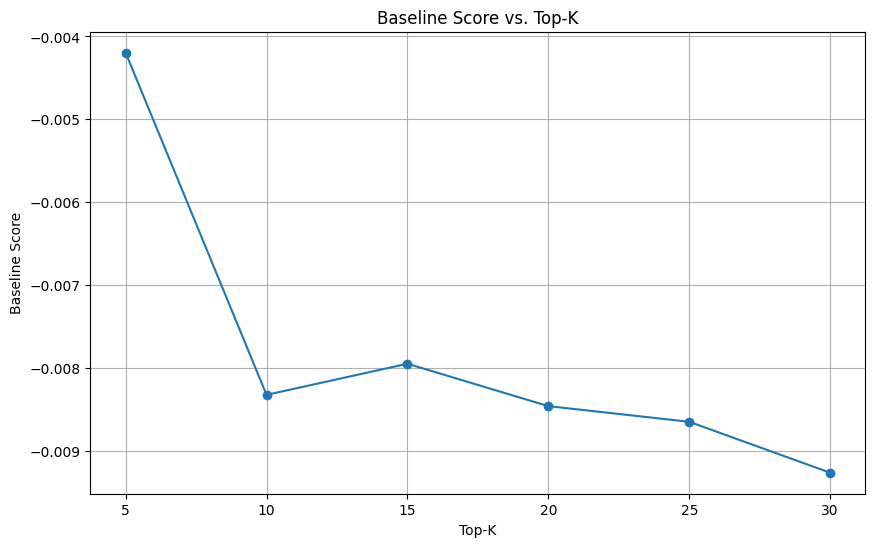

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(top_k_set, baseline_scores, marker='o')
plt.xlabel('Top-K')
plt.ylabel('Baseline Score')
plt.title('Baseline Score vs. Top-K')
plt.grid(True)
plt.show()


# **Manual Circuit Analysis for Positive & Negative Datasets.**

## **Baseline Scoring**

In [34]:
### Baseline score for Countries where gpt2 shows more positive sentiment
baseline_pos_dataset = evaluate_baseline(model, pos_dataset, metric).mean()
print((f"\n Baseline performance of positive dataset: {baseline_pos_dataset}"))

100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


 Baseline performance of positive dataset: -0.011863517574965954


In [35]:
### Baseline score for Countries where gpt2 shows more negative sentiment
baseline_neg_dataset = evaluate_baseline(model, neg_dataset, metric).mean()
print((f"\n Baseline performance of negative dataset: {baseline_neg_dataset}"))

100%|██████████| 124/124 [00:26<00:00,  4.68it/s]


 Baseline performance of negative dataset: -0.0054669626988470554


In [36]:
### Graph_Baseline score for Countries where gpt2 shows more positive sentiment
graph_baseline_pos = evaluate_graph(model, g, pos_dataset, metric).mean()
print((f"\n Graph_Baseline performance for positive dataset: {graph_baseline_pos}"))

100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


 Graph_Baseline performance for positive dataset: -0.027081618085503578


In [37]:
### Graph_Baseline score for Countries where gpt2 shows more negative sentiment
graph_baseline_neg = evaluate_graph(model, g, neg_dataset, metric).mean()
print((f"\n Graph_Baseline performance for Negative dataset: {graph_baseline_neg}"))

100%|██████████| 124/124 [00:37<00:00,  3.31it/s]


 Graph_Baseline performance for Negative dataset: -0.05080980807542801


## **Getting Top 3 Edges via Score for Positive & Negative Datasets**

Top 3 edge via score for Negative Dataset

In [ ]:
source = 'm11'
target = 'logits'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric_neg = evaluate_graph(model, g, neg_dataset, metric).mean()
g.edges[edge_name].in_graph = True
print("\n")
print(f"The difference between the negative patched metric and Graph_baseline negative is: {patched_metric_neg - graph_baseline_neg }")

100%|██████████| 124/124 [00:35<00:00,  3.48it/s]



The difference between the negative patched metric and Graph_baseline negative is: -0.05326453968882561


In [ ]:
source = 'm0'
target = 'm2'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric_neg = evaluate_graph(model, g, neg_dataset, metric).mean()
g.edges[edge_name].in_graph = True
print("\n")
print(f"The difference between the negative patched metric and Graph_baseline negative is: {patched_metric_neg - graph_baseline_neg }")

100%|██████████| 124/124 [00:34<00:00,  3.64it/s]



The difference between the negative patched metric and Graph_baseline negative is: -0.02245420590043068


In [ ]:
source = 'm0'
target = 'a4.h8<q>'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric_neg = evaluate_graph(model, g, neg_dataset, metric).mean()
g.edges[edge_name].in_graph = True
print("\n")
print(f"The difference between the negative patched metric and Graph_baseline negative is: {patched_metric_neg - graph_baseline_neg }")

100%|██████████| 124/124 [00:33<00:00,  3.67it/s]



The difference between the negative patched metric and Graph_baseline negative is: -0.03862759843468666


Top 3 edges via score for Positive dataset

In [ ]:
### Contribution of the edge m10->m2 for Countries where gpt2 shows more positive sentiment
source = 'm0'
target = 'm2'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric_pos = evaluate_graph(model, g, pos_dataset, metric).mean()
g.edges[edge_name].in_graph = True
print("\n")
print(f"The difference between the positive patched metric and Graph_baseline positive is: {patched_metric_pos - graph_baseline_pos}")

100%|██████████| 100/100 [00:28<00:00,  3.57it/s]



The difference between the positive patched metric and Graph_baseline positive is: 0.02703220769762993


In [ ]:
### Contribution of the edge m11->logits for Countries where gpt2 shows more positive sentiment
source = 'm11'
target = 'logits'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric_pos = evaluate_graph(model, g, pos_dataset, metric).mean()
g.edges[edge_name].in_graph = True
print("\n")
print(f"The difference between the positive patched metric and Graph_baseline positive is: {patched_metric_pos - graph_baseline_pos}")

100%|██████████| 100/100 [00:27<00:00,  3.58it/s]



The difference between the positive patched metric and Graph_baseline positive is: -0.0013651158660650253


In [ ]:
### Contribution of the edge a11.h0->logits for Countries where gpt2 shows more positive sentiment
source = 'a11.h0'
target = 'logits'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric_pos = evaluate_graph(model, g, pos_dataset, metric).mean()
g.edges[edge_name].in_graph = True
print("\n")
print(f"The difference between the positive patched metric and Graph_baseline positive is: {patched_metric_pos - graph_baseline_pos}")

100%|██████████| 100/100 [00:28<00:00,  3.54it/s]



The difference between the positive patched metric and Graph_baseline positive is: -0.005283765494823456


# **Manual Circuit Analysis for whole Dataset**

In [ ]:
baseline = evaluate_baseline(model, dataset, metric).mean()
print("\n")
print((f"Baseline performance: {baseline}"))

100%|██████████| 224/224 [00:43<00:00,  5.09it/s]



Baseline performance: -0.008322576992213726


In [ ]:
source = 'input'
target = 'logits'
edge_name = f'{source}->{target}'
g.edges[edge_name].in_graph = False
patched_metric = evaluate_graph(model, g, dataset, metric).mean()
g.edges[edge_name].in_graph = True
print("\n")
print(f"The difference between the patched metric and baseline is: {patched_metric - baseline}")

100%|██████████| 224/224 [01:03<00:00,  3.53it/s]



The difference between the patched metric and baseline is: -0.10027528554201126


In [ ]:
g_manual = Graph.from_model(model)
for edge in g_manual.edges.values():
    edge.in_graph=False

input_node = g_manual.nodes['input']
low_attn = ['a0.h3', 'a0.h5']
low_mlps = ['a0.h1', 'm0', 'm1', 'm2', 'm3']
mid_attn = ['a5.h1', 'a5.h5','a6.h1','a6.h9', 'a7.h10', 'a8.h8', 'a8.h11', 'a9.h1']
high_mlps = [f'm{i}' for i in range(8,12)]
logit_node = g_manual.nodes['logits']

for node in low_attn + low_mlps:
    if f'input->{node}' in g_manual.edges:
        g_manual.edges[f'input->{node}'].in_graph = True
    else:
        for letter in 'qkv':
            g_manual.edges[f'input->{node}<{letter}>'].in_graph = True

    for node2 in mid_attn:
        for letter in 'qkv':
            g_manual.edges[f'{node}->{node2}<{letter}>'].in_graph = True

for i, node in enumerate(low_mlps):
    for node2 in low_mlps[i+1:]:
        g_manual.edges[f'{node}->{node2}'].in_graph = True

for node in mid_attn:
    g_manual.edges[f'{node}->logits'].in_graph=True
    for node2 in high_mlps:
        edge_str = f'{node}->{node2}'
        if edge_str in g_manual.edges:
            g_manual.edges[edge_str].in_graph=True

for i, node in enumerate(high_mlps):
    g_manual.edges[f'{node}->logits'].in_graph=True
    for node2 in high_mlps[i+1:]:
        g_manual.edges[f'{node}->{node2}'].in_graph = True
g_manual.prune_dead_nodes(prune_childless=True, prune_parentless=True)
results = evaluate_graph(model, g_manual, dataset, metric).mean()
print("\n")
print(f"baseline performance: {baseline}. circuit performance: {results}")

100%|██████████| 224/224 [01:24<00:00,  2.66it/s]



baseline performance: -0.008322576992213726. circuit performance: -0.235609769821167


In [ ]:
print(f"The difference between the circuit and baseline performances is: {results - baseline}")

The difference between the circuit and baseline performances is: -0.2272871881723404


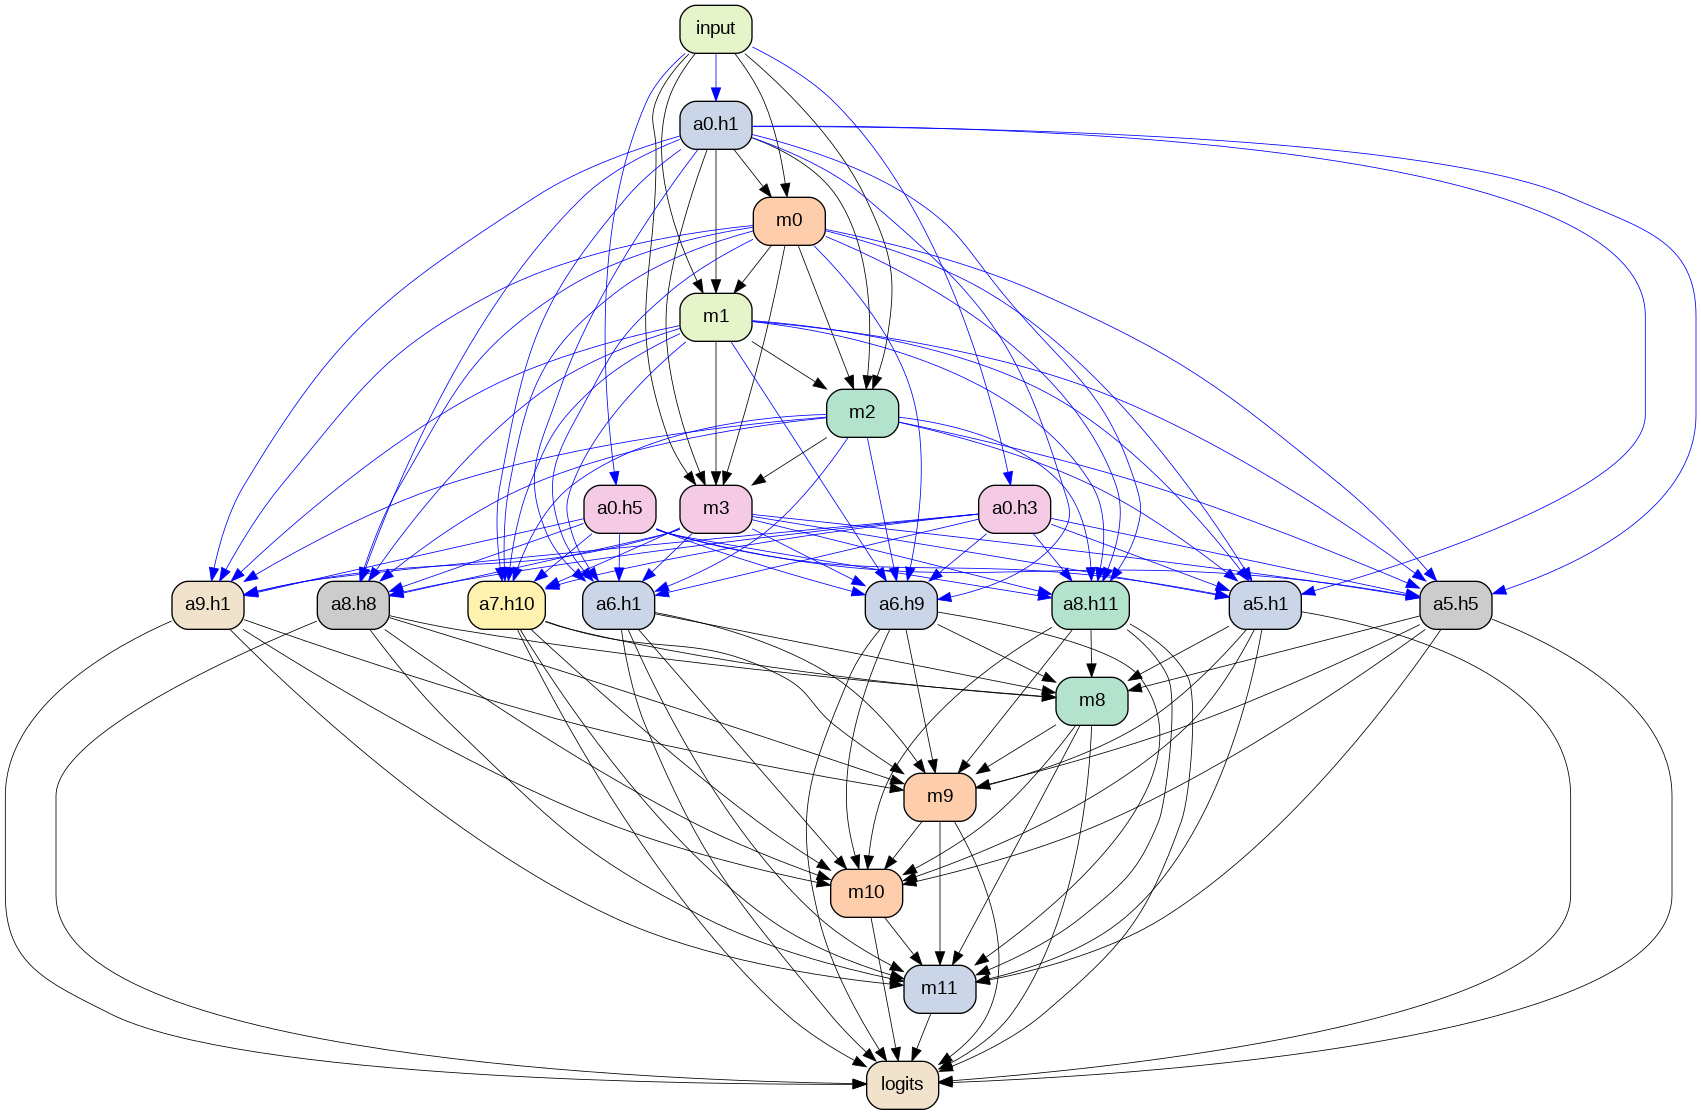

In [ ]:
for edge in g_manual.edges.values():
    if edge.score is None:
        edge.score = 0
gz_manual = g_manual.to_graphviz()
gz_manual.draw('graph_manual.png', prog='dot')
Image(filename='graph_manual.png')

# **Edge Attribution Patching**

## **EAP Attribute Function**

In [38]:

def get_npos_input_lengths(model, inputs):
    tokenized = model.tokenizer(inputs, padding='longest', return_tensors='pt', add_special_tokens=True)
    n_pos = 1 + tokenized.attention_mask.size(1)
    input_lengths = 1 + tokenized.attention_mask.sum(1)
    return n_pos, input_lengths

def make_hooks_and_matrices(model: HookedTransformer, graph: Graph, batch_size:int , n_pos:int, scores):
    activation_difference = torch.zeros((batch_size, n_pos, graph.n_forward, model.cfg.d_model), device='cuda', dtype=model.cfg.dtype)

    processed_attn_layers = set()
    fwd_hooks_clean = []
    fwd_hooks_corrupted = []
    bwd_hooks = []

    def activation_hook(index, activations, hook, add:bool=True):
        acts = activations.detach()
        if not add:
            acts = -acts
        try:
            activation_difference[:, :, index] += acts
        except RuntimeError as e:
            print(hook.name, activation_difference[:, :, index].size(), acts.size())
            raise e

    def gradient_hook(fwd_index: Union[slice, int], bwd_index: Union[slice, int], gradients:torch.Tensor, hook):
        grads = gradients.detach()
        try:
            if isinstance(fwd_index, slice):
                fwd_index = fwd_index.start
            if grads.ndim == 3:
                grads = grads.unsqueeze(2)
            s = einsum(activation_difference[:, :, :fwd_index], grads,'batch pos forward hidden, batch pos backward hidden -> forward backward')
            s = s.squeeze(1)
            scores[:fwd_index, bwd_index] += s
        except RuntimeError as e:
            print(hook.name, activation_difference.size(), grads.size())
            raise e

    for name, node in graph.nodes.items():
        if isinstance(node, AttentionNode):
            if node.layer in processed_attn_layers:
                continue
            else:
                processed_attn_layers.add(node.layer)

        # exclude logits from forward
        fwd_index =  graph.forward_index(node)
        if not isinstance(node, LogitNode):
            fwd_hooks_corrupted.append((node.out_hook, partial(activation_hook, fwd_index)))
            fwd_hooks_clean.append((node.out_hook, partial(activation_hook, fwd_index, add=False)))
        if not isinstance(node, InputNode):
            if isinstance(node, AttentionNode):
                for i, letter in enumerate('qkv'):
                    bwd_index = graph.backward_index(node, qkv=letter)
                    bwd_hooks.append((node.qkv_inputs[i], partial(gradient_hook, fwd_index, bwd_index)))
            else:
                bwd_index = graph.backward_index(node)
                bwd_hooks.append((node.in_hook, partial(gradient_hook, fwd_index, bwd_index)))

    return (fwd_hooks_corrupted, fwd_hooks_clean, bwd_hooks), activation_difference

######                #######
#####  Edit from here  #######
#####                 #######

def get_scores(model: HookedTransformer, graph: Graph, dataset, metric: Callable[[Tensor], Tensor]):
    scores = torch.zeros((graph.n_forward, graph.n_backward), device='cuda', dtype=model.cfg.dtype)

    total_items = 0
    for sentence, corrupted in tqdm(dataset):
        sens = [sentence, corrupted]
        sens = [str(s) for s in sens]
        max_length = max(len(model.tokenizer.tokenize(s)) for s in sens)
        padded_sentences = [model.tokenizer.encode(s, padding='max_length', max_length=max_length, return_tensors='pt', add_special_tokens=True) for s in sens]
        s1 = padded_sentences[0]
        s2 = padded_sentences[1]
        clean = model.tokenizer.decode(s1[0])
        corrupted_dash = model.tokenizer.decode(s2[0])

        batch_size = len(clean)
        total_items += batch_size
        n_pos, input_lengths = get_npos_input_lengths(model, clean)

        (fwd_hooks_corrupted, fwd_hooks_clean, bwd_hooks), activation_difference = make_hooks_and_matrices(model, graph, batch_size, n_pos, scores)

        with model.hooks(fwd_hooks=fwd_hooks_corrupted):
            corrupted_logits = model(corrupted_dash)

        with model.hooks(fwd_hooks=fwd_hooks_clean, bwd_hooks=bwd_hooks):
            logits = model(clean)
            label = torch.tensor(0, device='cuda', dtype=model.cfg.dtype)
            metric_value = metric(logits)
            metric_value.backward()

    scores /= total_items

    return scores

def get_scores_ig(model: HookedTransformer, graph: Graph, dataset, metric: Callable[[Tensor], Tensor], steps=30):
    scores = torch.zeros((graph.n_forward, graph.n_backward), device='cuda', dtype=model.cfg.dtype)

    total_items = 0
    for sentence, corrupted in tqdm(dataset):
        sens = [sentence, corrupted]
        sens = [str(s) for s in sens]
        max_length = max(len(model.tokenizer.tokenize(s)) for s in sens)
        padded_sentences = [model.tokenizer.encode(s, padding='max_length', max_length=max_length, return_tensors='pt', add_special_tokens=True) for s in sens]
        s1 = padded_sentences[0]
        s2 = padded_sentences[1]
        clean = model.tokenizer.decode(s1[0])
        corrupted_dash = model.tokenizer.decode(s2[0])

        batch_size = len(clean)
        total_items += batch_size
        n_pos, input_lengths = get_npos_input_lengths(model, clean)

        (fwd_hooks_corrupted, fwd_hooks_clean, bwd_hooks), activation_difference = make_hooks_and_matrices(model, graph, batch_size, n_pos, scores)

        with torch.inference_mode():
            with model.hooks(fwd_hooks=fwd_hooks_corrupted):
                _ = model(corrupted_dash)

            input_activations_corrupted = activation_difference[:, :, graph.forward_index(graph.nodes['input'])].clone()

            with model.hooks(fwd_hooks=fwd_hooks_clean):
                clean_logits = model(clean)

            input_activations_clean = input_activations_corrupted - activation_difference[:, :, graph.forward_index(graph.nodes['input'])]

        def input_interpolation_hook(k: int):
            def hook_fn(activations, hook):
                new_input = input_activations_clean + (k / steps) * (input_activations_corrupted - input_activations_clean)
                new_input.requires_grad = True
                return new_input
            return hook_fn

        total_steps = 0
        for step in range(1, steps+1):
            total_steps += 1
            with model.hooks(fwd_hooks=[(graph.nodes['input'].out_hook, input_interpolation_hook(step))], bwd_hooks=bwd_hooks):
                logits = model(clean)
                label = torch.tensor(0, device='cuda', dtype=model.cfg.dtype)
                metric_value = metric(logits)
                metric_value.backward()

    scores /= total_items
    scores /= total_steps

    return scores

allowed_aggregations = {'sum', 'mean', 'l2'}

### Done upto here #########


def attribute(model: HookedTransformer, graph: Graph, dataset, metric: Callable[[Tensor], Tensor], aggregation='sum', integrated_gradients: Optional[int]=None):
    if aggregation not in allowed_aggregations:
        raise ValueError(f'aggregation must be in {allowed_aggregations}, but got {aggregation}')


    if integrated_gradients is None:
        scores = get_scores(model, graph, dataset, metric)
    else:
        assert integrated_gradients > 0, f"integrated_gradients gives positive # steps (m), but got {integrated_gradients}"
        scores = get_scores_ig(model, graph, dataset, metric, steps=integrated_gradients)

        if aggregation == 'mean':
            scores /= model.cfg.d_model
        elif aggregation == 'l2':
            scores = torch.linalg.vector_norm(scores, ord=2, dim=-1)

    scores = scores.cpu().numpy()

    for edge in tqdm(graph.edges.values(), total=len(graph.edges)):
        edge.score = scores[graph.forward_index(edge.parent, attn_slice=False), graph.backward_index(edge.child, qkv=edge.qkv, attn_slice=False)]

## **EAP and finding best scoring edges for positive Dataset**

In [39]:
attribute(model, g, pos_dataset, partial(metric, loss=True, mean=True))

100%|██████████| 32491/32491 [00:00<00:00, 402720.91it/s]


In [40]:
# include all edges whose absolute score is >= the 4th greatest absolute score
scores = g.scores(absolute=True)
# using a greedy search over the graph, starting from the logits, add in the highest-scoring edges (non-absolute)
#g.apply_greedy(2000)

In [41]:
print(scores[-3:])

tensor([0.0183, 0.0324, 0.0338])


In [42]:
# Checking the saturation in edge scores
No_of_top_scoring_edge = np.arange(0, 32491, 400)
least_score_saturated = []
for num in No_of_top_scoring_edge:
  least_score_saturated.append(scores[num])

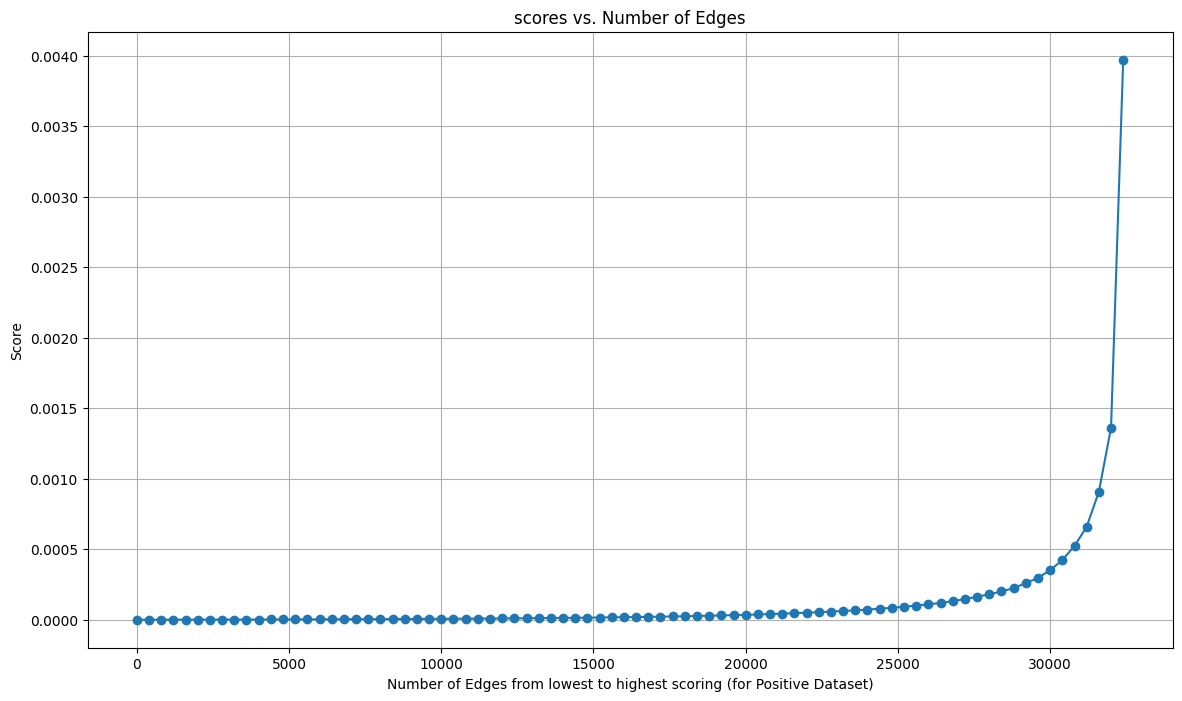

In [43]:
plt.figure(figsize=(14,8))
plt.plot(No_of_top_scoring_edge, least_score_saturated, marker='o')
plt.xlabel('Number of Edges from lowest to highest scoring (for Positive Dataset)')
plt.ylabel('Score')
plt.title('scores vs. Number of Edges')
plt.grid(True)
plt.show()

In [44]:
# Get the remaining edges as a list
remaining_edges = list(g.edges.items())

# Sort edges by their score (descending order)
remaining_edges.sort(key=lambda x: abs(x[1].score), reverse=True)

# Print the top 10 edges
for i, (edge_id, edge) in enumerate(remaining_edges[:10]):
    print(edge)
    print(f"  Score: {abs(edge.score)}")

Edge(m0->m2)
  Score: 0.03382052108645439
Edge(m11->logits)
  Score: 0.0323832631111145
Edge(a11.h0->logits)
  Score: 0.018258245661854744
Edge(a1.h8->m2)
  Score: 0.01787465624511242
Edge(m0->a3.h5<q>)
  Score: 0.017694320529699326
Edge(m0->a4.h8<q>)
  Score: 0.016485223546624184
Edge(m1->m2)
  Score: 0.015458369627594948
Edge(m9->logits)
  Score: 0.014295345172286034
Edge(m0->m3)
  Score: 0.012221265584230423
Edge(m2->m3)
  Score: 0.011429988779127598


In [ ]:
for i, (edge_id, edge) in enumerate(remaining_edges[:10]):


In [ ]:
g.apply_threshold(scores[-10], absolute=True)

In [ ]:
g.prune_dead_nodes()

In [ ]:
print(f"The auto-circuit has {g.count_included_edges()} edges")

The auto-circuit has 31894 edges


In [ ]:
results = evaluate_graph(model, g, pos_dataset, metric).mean()
print(f"\nGraph_baseline_positive performance: {graph_baseline_pos}. positive_ablated_circuit performance: {results}")
print(f"The score difference between original and ablated circuits = {graph_baseline_pos - results}")

100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


Graph_baseline_positive performance: -0.027081701904535294. positive_ablated_circuit performance: 0.03997630625963211
The score difference between original and ablated circuits = -0.0670580118894577


In [ ]:
# Ablating the top N edges in the graph and recording the evaluate graph scores
Score_thresholds_pos =[1,2,4,6,6,10]
Num_of_top_edges_ablated_pos =[]
G_baseline_scores_pos =[]
for m in Score_thresholds_pos:
  g.apply_threshold(scores[-m], absolute=True)
  g.prune_dead_nodes()
  Num_of_top_edges_ablated_pos.append(32491 - g.count_included_edges())
  res = evaluate_graph(model,g,pos_dataset,metric).mean()
  G_baseline_scores_pos.append(res)

100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


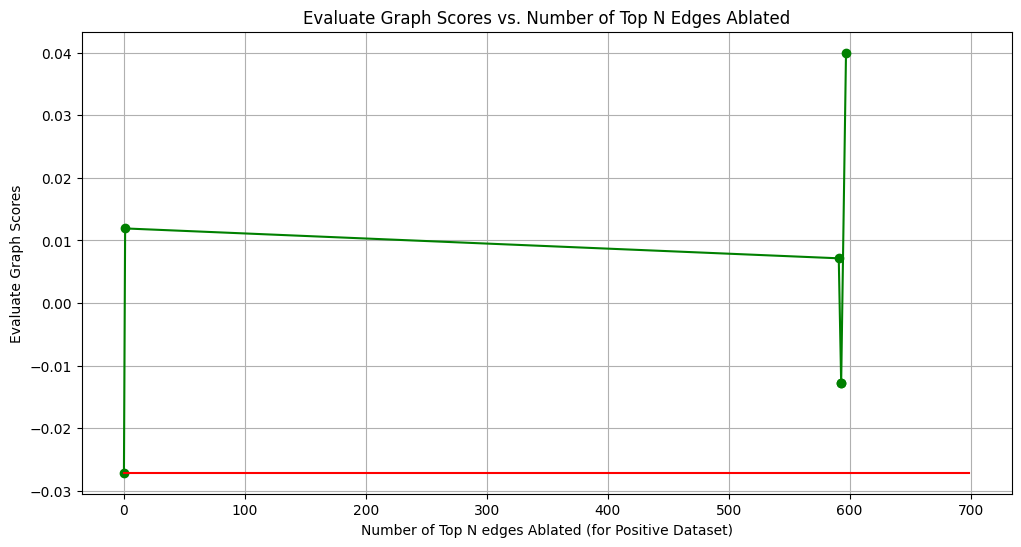

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(Num_of_top_edges_ablated_pos, G_baseline_scores_pos, marker='o',color='green')
plt.xlabel('Number of Top N edges Ablated (for Positive Dataset)')
plt.ylabel('Evaluate Graph Scores')
plt.title('Evaluate Graph Scores vs. Number of Top N Edges Ablated')
plt.plot(list(range(0,700)),[graph_baseline_pos]*700,color='red')
plt.grid(True)
plt.show()

## **EAP and finding best scoring edges for negative Dataset.**

In [ ]:
attribute(model, g1, neg_dataset, partial(metric, loss=True, mean=True))

100%|██████████| 32491/32491 [00:00<00:00, 519044.20it/s]


In [ ]:
# include all edges whose absolute score is >= the 2000th greatest absolute score
scores = g1.scores(absolute=True)

In [ ]:
print(scores[-3:])

tensor([0.0449, 0.0537, 0.0759])


In [ ]:
# Checking the saturation in edge scores
No_of_top_scoring_edge = np.arange(0, 32491, 400)
least_score_saturated = []
for num in No_of_top_scoring_edge:
  least_score_saturated.append(scores[num])

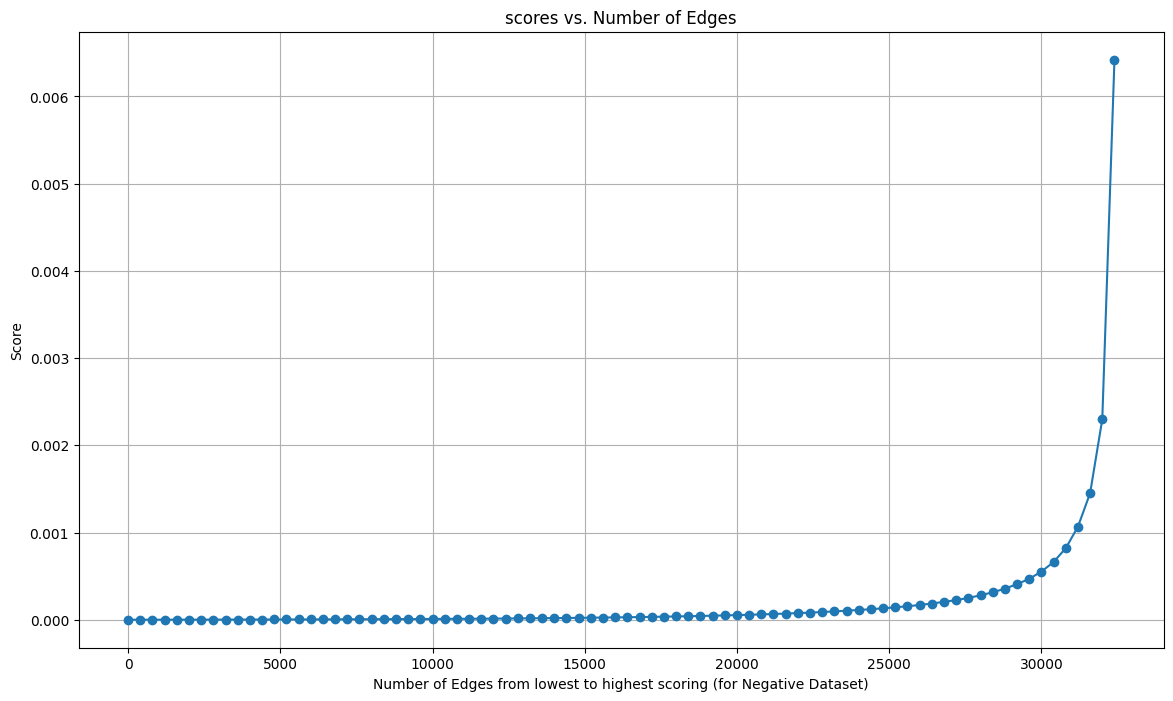

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(No_of_top_scoring_edge, least_score_saturated, marker='o')
plt.xlabel('Number of Edges from lowest to highest scoring (for Negative Dataset)')
plt.ylabel('Score')
plt.title('scores vs. Number of Edges')
plt.grid(True)
plt.show()

In [ ]:
g1.apply_threshold(scores[-10], absolute=True)

In [ ]:
g1.prune_dead_nodes()

In [ ]:
print(f"The auto-circuit has {g1.count_included_edges()} edges")

The auto-circuit has 31894 edges


In [ ]:
results1 = evaluate_graph(model, g1, neg_dataset, metric).mean()
print(f"Graph_baseline_negative performance: {graph_baseline_neg}. negative_ablated_circuit performance: {results1}")
print(f"The score difference between original and ablated circuits = {graph_baseline_neg - results1}")

100%|██████████| 124/124 [00:35<00:00,  3.53it/s]

Graph_baseline_negative performance: -0.0508098341524601. negative_ablated_circuit performance: 0.018876653164625168
The score difference between original and ablated circuits = -0.06968648731708527


In [ ]:
# Ablating the top N edges in the graph and recording the evaluate graph scores
Score_thresholds_neg =[1,2,4,6,6,10]
Num_of_top_edges_ablated_neg =[]
G_baseline_scores_neg =[]
for m in Score_thresholds_neg:
  g1.apply_threshold(scores[-m], absolute=True)
  g1.prune_dead_nodes()
  Num_of_top_edges_ablated_neg.append(32491 - g1.count_included_edges())
  res = evaluate_graph(model,g1,neg_dataset,metric).mean()
  G_baseline_scores_neg.append(res)

100%|██████████| 124/124 [00:34<00:00,  3.62it/s]


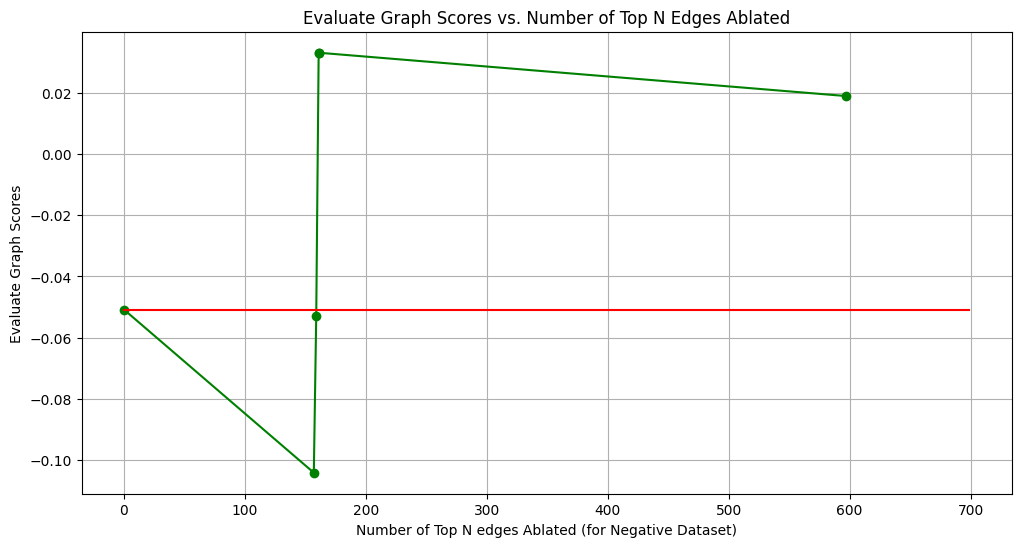

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(Num_of_top_edges_ablated_neg, G_baseline_scores_neg, marker='o',color='green')
plt.xlabel('Number of Top N edges Ablated (for Negative Dataset)')
plt.ylabel('Evaluate Graph Scores')
plt.title('Evaluate Graph Scores vs. Number of Top N Edges Ablated')
plt.plot(list(range(0,700)),[graph_baseline_neg]*700,color='red')
plt.grid(True)
plt.show()

In [ ]:
# Get the remaining edges as a list
remaining_edges = list(g1.edges.items())

# Sort edges by their score (descending order)
remaining_edges.sort(key=lambda x: abs(x[1].score), reverse=True)

# Print the top 10 edges
for i, (edge_id, edge) in enumerate(remaining_edges[:3]):
    print(edge)
    print(f"  Score: {abs(edge.score)}")

Edge(m11->logits)
  Score: 0.0759383961558342
Edge(m0->m2)
  Score: 0.05372548848390579
Edge(m0->a4.h8<q>)
  Score: 0.0449339859187603
